In [24]:
import matplotlib.pyplot as plt
import numpy as np
import os

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dense, Dropout, Flatten, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [25]:
INIT_LR = 1e-4
EPOCHS = 15
BS = 32

In [26]:
DIRECTORY = r"C:\Users\RianL\OneDrive\Documents\Junior\Artificial_Intelligence\Final-Project\DATA"
CATEGORIES = ["MASK", "NO_MASK"]
data = []
labels = []

In [27]:
print("[INFO] loading images...")

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

[INFO] loading images...


In [28]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [29]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [30]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [31]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest"
)

In [32]:
print("[INFO] preparing model layers...")

baseModel = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

[INFO] preparing model layers...


In [33]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [34]:
print("[INFO] providing a summary of the model...")

model.summary()

t[0][0]            
__________________________________________________________________________________________________
block_7_expand (Conv2D)         (None, 14, 14, 384)  24576       block_6_project_BN[0][0]         
__________________________________________________________________________________________________
block_7_expand_BN (BatchNormali (None, 14, 14, 384)  1536        block_7_expand[0][0]             
__________________________________________________________________________________________________
block_7_expand_relu (ReLU)      (None, 14, 14, 384)  0           block_7_expand_BN[0][0]          
__________________________________________________________________________________________________
block_7_depthwise (DepthwiseCon (None, 14, 14, 384)  3456        block_7_expand_relu[0][0]        
__________________________________________________________________________________________________
block_7_depthwise_BN (BatchNorm (None, 14, 14, 384)  1536        block_7_depthwise[0][0] 

In [35]:
for layer in baseModel.layers:
	layer.trainable = False

In [36]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [37]:
print("[INFO] training model...")

H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS
)

[INFO] training model...
Epoch 1/15
8/8 [==============================] - 11s 1s/step - loss: 0.5064 - accuracy: 0.7822 - val_loss: 0.3755 - val_accuracy: 0.7692
Epoch 2/15
8/8 [==============================] - 8s 1s/step - loss: 0.4626 - accuracy: 0.7822 - val_loss: 0.3713 - val_accuracy: 0.7846
Epoch 3/15
8/8 [==============================] - 9s 1s/step - loss: 0.4137 - accuracy: 0.8222 - val_loss: 0.3162 - val_accuracy: 0.8308
Epoch 4/15
8/8 [==============================] - 8s 1s/step - loss: 0.3329 - accuracy: 0.8311 - val_loss: 0.2905 - val_accuracy: 0.8462
Epoch 5/15
8/8 [==============================] - 9s 1s/step - loss: 0.3240 - accuracy: 0.8489 - val_loss: 0.3069 - val_accuracy: 0.8462
Epoch 6/15
8/8 [==============================] - 10s 1s/step - loss: 0.2575 - accuracy: 0.8844 - val_loss: 0.3151 - val_accuracy: 0.8462
Epoch 7/15
8/8 [==============================] - 8s 1s/step - loss: 0.2772 - accuracy: 0.8844 - val_loss: 0.2894 - val_accuracy: 0.8615
Epoch 8/15
8/8

In [38]:
print("[INFO] evaluating network...")

predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [39]:
predIdxs = np.argmax(predIdxs, axis=1)

In [40]:
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

        MASK       0.71      1.00      0.83        15
     NO_MASK       1.00      0.88      0.94        50

    accuracy                           0.91        65
   macro avg       0.86      0.94      0.88        65
weighted avg       0.93      0.91      0.91        65



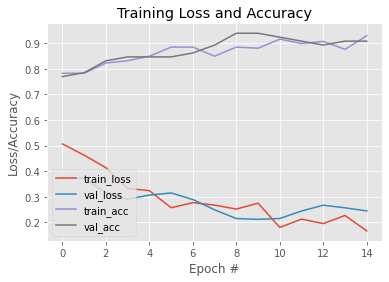

In [41]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [42]:
print("[INFO] saving mask detector model...")

model.save(r"C:\Users\RianL\OneDrive\Documents\Junior\Artificial_Intelligence\Final-Project\maskdetectsite\maskdetect\mask_detect.h5", save_format="h5")

[INFO] saving mask detector model...


In [43]:
print("[INFO] testing mask detector model...")

model = load_model("mask_detect.h5")
test_data = []

[INFO] testing mask detector model...


In [44]:
fname = 'stevejobs.jpeg'
image = load_img(fname, target_size=(224, 224))
image = img_to_array(image)
image = preprocess_input(image)

In [45]:
test_data.append(image)
test_data = np.array(test_data, dtype='float32')

In [46]:
print("[INFO] model should predict a 0 in column 1 for the stevejobs.jpeg having no mask...")

test_predIdxs = model.predict(test_data)
test_predIdxs[:,0].round()

[INFO] model should predict a 0 in column 1 for the stevejobs.jpeg having no mask...


array([0.], dtype=float32)